### Regional wettest and driest polygons with subgrid of 0.5 degrees for largest polygon



This code takes a shapefile of areas with common driest years. 

-It loops through the polygons in the shapefile and calculates 5th and 95th percentile in rainfall from the BoM rainfall data, and returns the years which are over/under those margins.

-for each shapefile it will add the wet and dry years to the polygon attribute table

-code by Bex Dunn April 2017

-dependencies:
-shapefile (called twice)


In [63]:
# Import the libraries we need in the code and tell matplotlib to display the plots inline
%matplotlib inline
import fiona
import geopandas as gpd
import datacube
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import scipy.stats
import pandas
#import csv
import os

#import warnings to handle the rasterio warnings thrown by the datacube
import warnings

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

import pickle
import logging
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#python logging 
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)
dc = datacube.Datacube(app='dc-BOMrainfall')

In [64]:
#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("once")
    fxn()

/g/data/v10/public/modules/agdc-py3-env/20170327/envs/agdc/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: deprecated


In [65]:
#Use geopandas to read in the attribute table as a geodataframe

In [66]:
#big_poly = gpd.read_file('/g/data/r78/rjd547/groundwater_activities/Rain/burdekin_combo_shp_260417.shp')

big_poly = gpd.read_file('/g/data/r78/rjd547/groundwater_activities/Rain/bur_combo_shape_270417/bur_shape_280417.shp')

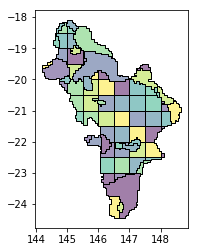

In [67]:
big_poly.plot()
plt.show()

In [68]:
#create an empty column
big_poly['WY1'] = None
big_poly['WY2'] = None
big_poly['DY1'] = None
big_poly['DY2'] = None

In [69]:
big_poly.tail()

,DN,DY1,DY2,ID,WY1,WY2,area,geometry
68,1994,None,None,72,None,None,4.569893e+08,"POLYGON ((146.55 -21.99999999999996, 146.65 -2..."
69,2001,None,None,73,None,None,7.673951e+08,"POLYGON ((147.45 -22.59999999999999, 147.65 -2..."
70,1993,None,None,74,None,None,5.067565e+08,"POLYGON ((146.65 -23.94999999999996, 146.75 -2..."
71,1990,None,None,75,None,None,2.139736e+09,"POLYGON ((146.35 -23.75, 146.65 -23.7499999999..."
72,2002,None,None,76,None,None,NaN,"POLYGON ((147.15 -23.00000000000001, 147.35 -2..."


In [ ]:
#try to catch a rasterio warning that the datacube produces multiple times while accessing the rainfall data
#fxn()
# #pick a shape file
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Rain/bur_combo_shape_270417/bur_shape_280417.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)
for i in range(len(shapes)): 
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)
    #print(shapes[i]['properties']['DN'], shapes[0]['properties']['Id'])
    #print (geom_bs)

    query = {
           'time': ('1987-10-01','2012-10-01'),
    #          'x': (geom.bounds[0], geom.bounds[2]),
    #          'y': (geom.bounds[1], geom.bounds[3]),
           'geopolygon': geom
    #         'crs': geom_crs,
        }
     #setup rain directory for our pickle data
    rainpath ='/g/data/r78/rjd547/groundwater_activities/Rain/'+shape_name+'/'
    try:
            os.mkdir(rainpath)
    except OSError as err:
            print("OS error: {0}".format(err))
    try:
        #try to get the rain data from a pickle file saved earlier 
        f = open(rainpath+'/Rainfall_data'+'.pkl', 'rb')
        rain = pickle.load(f)
        Studysite_rain = rain['Studysite_rain']
        print('loaded rainfall grids from file:'+rainpath+'Rainfall_data.pkl')
        f.close()
    except:
        #Grab bom_rainfall_grids from the datacube
        print('loaded bom rainfall grids from datacube')
        Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
        #make a dictionary of the data we want to save
        vars2pickle = {'Studysite_rain':Studysite_rain}
        f = open(rainpath+'/Rainfall_data'+'.pkl', 'wb')
        pickle.dump(vars2pickle,f) 
        print('saved rainfall data to file')
        #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
        f.close()   

    #Mask the data with the polygon. Invert = True means you want the contents of the mask
    #I've added 'all touched = True, otherwise we get nothing in the output.
    mask = geometry_mask([geom], Studysite_rain.geobox, all_touched=True,invert=True)
    Studysite_rain_masked = Studysite_rain.where(mask)

    #resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
    #Note that the resampling we did means that each year is labelled according to its first day  
    year_avg = Studysite_rain_masked.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)

    # Create a spatial average
    year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

    # Find the 95th percentile in rainfall
    threshold95 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 95)

    # Find the 5th percentile in rainfall (least)
    threshold5 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 5)
    #print('5th  q: ',threshold5.rainfall.values,'\n'+'95th q: ',threshold95.rainfall.values )

    #work out which of the years have rainfall greater than 95th and less than 5th percentile
    wet_yrs = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).dropna(dim = 'time')
    dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

    #turn into numpy datetimes for later timeslicing
    wet_dt=np.array(wet_yrs.time.values,dtype = 'datetime64[Y]')
    dry_dt=np.array(dry_yrs.time.values,dtype = 'datetime64[Y]')
    
    #if we get no values for wet year and dry year, give zeroes instead
    if wet_dt.size == 0:
        wet_dt =np.zeros(2)
        dry_dt =np.zeros(2)
    
    #print out our wet and dry years
    print('wet years begin: ', wet_dt)
    print('dry years begin: ', dry_dt)

    #type(wet_dt[0])
    print(i)
    print('driest year is :',big_poly.DN[i])

    #now add the wet and dry years back into the geodataframe
    big_poly.set_value(big_poly.index[i],'WY1',str(wet_dt[0]))
    big_poly.set_value(big_poly.index[i],'WY2',str(wet_dt[1]))
    big_poly.set_value(big_poly.index[i],'DY1',str(dry_dt[0]))
    big_poly.set_value(big_poly.index[i],'DY2',str(dry_dt[1]))

loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1993']
0
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1994']
1
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2008']
dry years begin:  ['1992' '1993']
2
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1993']
3
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2008']
dry years begin:  ['1992' '1993']
4
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1993']
5
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1993']
6
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1994']
7
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1994']
8
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1994']
9
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2010']
dry years begin:  ['1992' '2003']
10
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2011']
dry years begin:  ['1991' '1992']
11
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
12
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2003']
13
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2010']
dry years begin:  ['1992' '2003']
14
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2010' '2011']
dry years begin:  ['1991' '1992']
15
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2010' '2011']
dry years begin:  ['1991' '1992']
16
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '1993']
17
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2002']
18
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
19
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2011']
dry years begin:  ['1991' '1992']
20
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2010' '2011']
dry years begin:  ['1992' '2002']
21
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2010']
dry years begin:  ['1992' '1994']
22
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1988' '1990']
dry years begin:  ['1992' '1994']
23
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2010' '2011']
dry years begin:  ['1992' '1994']
24
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2008' '2010']
dry years begin:  ['1992' '1995']
25
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
26
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2010']
dry years begin:  ['1992' '2002']
27
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2010' '2011']
dry years begin:  ['1992' '1994']
28
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2002']
29
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2003']
30
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['1990' '2010']
dry years begin:  ['1991' '1992']
31
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2009' '2011']
dry years begin:  ['1991' '1992']
32
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2011']
dry years begin:  ['1991' '1992']
33
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2011']
dry years begin:  ['1991' '1992']
34
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2002']
35
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2009']
dry years begin:  ['1992' '2002']
36
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2009']
dry years begin:  ['1992' '2002']
37
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  [ 0.  0.]
dry years begin:  [ 0.  0.]
38
driest year is : 1992
loaded bom rainfall grids from datacube


/g/data/v10/public/modules/agdc-py3/1.3.0/lib/python3.5/site-packages/datacube/utils/__init__.py:178: RuntimeWarning: invalid value encountered in double_scalars
  res = (data[data.size - 1] - data[0]) / (data.size - 1.0)
/g/data/v10/public/modules/agdc-py3-env/20170327/envs/agdc/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/g/data/v10/public/modules/agdc-py3-env/20170327/envs/agdc/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less_equal
  if not reflexive
/g/data/v10/public/modules/agdc-py3-env/20170327/envs/agdc/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in greater_equal
  if not reflexive


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2001']
39
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1992' '2001']
40
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2009']
dry years begin:  ['1992' '1994']
41
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2009']
dry years begin:  ['1992' '1994']
42
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
43
driest year is : 1992
loaded bom rainfall grids from datacube


saved rainfall data to file
wet years begin:  ['2007' '2010']
dry years begin:  ['1991' '1992']
44
driest year is : 1992
loaded bom rainfall grids from datacube


In [ ]:
big_poly

In [19]:
big_poly.get_value(big_poly.index[0],col='WY1')

'1990'

In [40]:
#big_poly.to_file('/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_Shapes/BurWetDryGrid270417.shp', 
                  driver='ESRI Shapefile')

In [ ]:
# big_poly.to_csv('/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_Shapes/BurWetDryGrid.csv')